# Assignment 5 - The Bootstarp

## Conceptual 

1 - Explain how k-fold cross-validation is implemented.

- K-fold cross-validation is implemented by randomly splitting the dataset into k approximately equal-sized parts called folds. The model is then trained k times, where each time a different fold is held out as a validation set and the remaining k−1 folds are used for training. For each repetition, a prediction error is computed on the held-out fold, and the k errors are averaged to produce the k-fold cross-validation estimate of test error.

2 - What are the advantages and disadvantages of k-fold crossvalidation relative to:

i. The validation set approach?

- Compared to the validation set approach, k-fold cross-validation typically gives a more reliable estimate of test error because it does not depend on a single random split of the data. Since every observation is used for validation once and for training multiple times, the estimate is usually less variable and uses the available data more efficiently. The main disadvantage is that the model must be fit k times, which increases computational cost relative to fitting the model once using a single validation split.

ii. LOOCV?

- Compared to leave-one-out cross-validation, k-fold cross-validation is usually far less computationally expensive when the dataset is large because it requires fitting the model only k times rather than n times. In practice, k-fold can also yield a more stable estimate because leave-one-out fits models on extremely similar training sets, which can make the resulting error estimates highly correlated and lead to higher variance. The disadvantage of k-fold relative to leave-one-out is that each model is trained on slightly fewer observations, which can introduce a small increase in bias in the estimated test error.

## Practical

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm


In [2]:
# Load data
Auto = pd.read_csv("Auto.csv")
if "Unnamed: 0" in Auto.columns:
    Auto = Auto.drop(columns=["Unnamed: 0"])
Auto["horsepower"] = pd.to_numeric(Auto["horsepower"], errors="coerce")
Auto = Auto.dropna().copy()
Auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


In [3]:
# Variables
Auto.shape[1], list(Auto.columns)

(9,
 ['mpg',
  'cylinders',
  'displacement',
  'horsepower',
  'weight',
  'acceleration',
  'year',
  'origin',
  'name'])

## Interpretation
This output shows how many variables the dataset contains and what their names are. After removing any extra index column and converting horsepower to a numeric variable, the remaining dataset is a clean version that will be used for all subsequent calculations and plots.

In [5]:
# Summary
Auto.drop(columns=["name"]).describe()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
count,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000,392.000000
mean,23.445918,5.471939,194.411990,104.469388,2977.584184,15.541327,75.979592,1.576531
std,7.805007,1.705783,104.644004,38.491160,849.402560,2.758864,3.683737,0.805518
min,9.000000,3.000000,68.000000,46.000000,1613.000000,8.000000,70.000000,1.000000
25%,17.000000,4.000000,105.000000,75.000000,2225.250000,13.775000,73.000000,1.000000
50%,22.750000,4.000000,151.000000,93.500000,2803.500000,15.500000,76.000000,1.000000
75%,29.000000,8.000000,275.750000,126.000000,3614.750000,17.025000,79.000000,2.000000
max,46.600000,8.000000,455.000000,230.000000,5140.000000,24.800000,82.000000,3.000000


In [6]:
# Sample size
Auto.shape[0]

392

## Interpretation
The summary table provides a quick check of the typical values and ranges for each numeric variable, including the minimum and maximum values. The printed row count is the effective sample size after removing observations with missing values, and this is the sample size used for both regression models and all bootstrap resamples.

In [7]:
# Correlation matrix
numeric_data = Auto.drop(columns=["name"])
corr_matrix = numeric_data.corr(numeric_only=True)
corr_matrix.round(3)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
mpg,1.000,-0.778,-0.805,-0.778,-0.832,0.423,0.581,0.565
cylinders,-0.778,1.000,0.951,0.843,0.898,-0.505,-0.346,-0.569
displacement,-0.805,0.951,1.000,0.897,0.933,-0.544,-0.370,-0.615
horsepower,-0.778,0.843,0.897,1.000,0.865,-0.689,-0.416,-0.455
weight,-0.832,0.898,0.933,0.865,1.000,-0.417,-0.309,-0.585
acceleration,0.423,-0.505,-0.544,-0.689,-0.417,1.000,0.290,0.213
year,0.581,-0.346,-0.370,-0.416,-0.309,0.290,1.000,0.182
origin,0.565,-0.569,-0.615,-0.455,-0.585,0.213,0.182,1.000


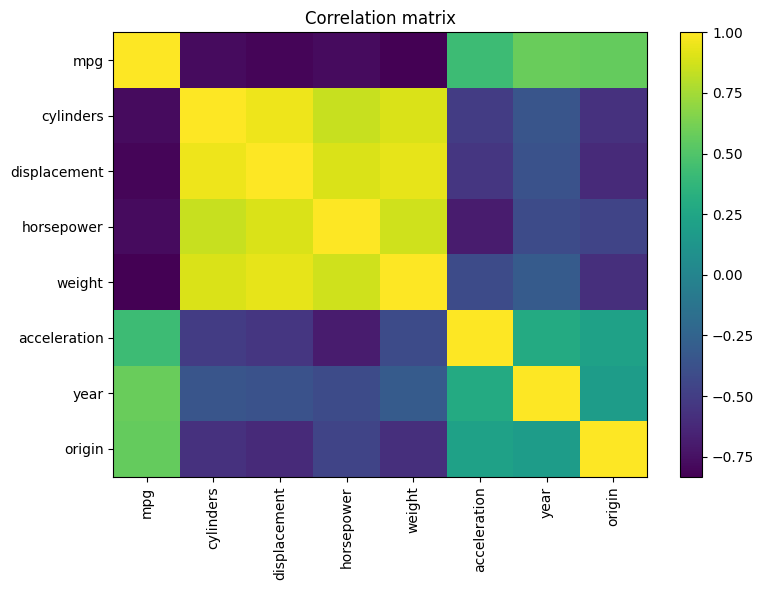

In [8]:
# Correlation heatmap
plt.figure(figsize=(8, 6))
img = plt.imshow(corr_matrix.values, aspect="auto")
plt.xticks(range(len(corr_matrix.columns)), corr_matrix.columns, rotation=90)
plt.yticks(range(len(corr_matrix.index)), corr_matrix.index)
plt.title("Correlation matrix")
plt.colorbar(img)
plt.tight_layout()
plt.show()

## Interpretation
The correlation matrix reveals clear structure in the data. Fuel efficiency measured by mpg is strongly negatively associated with weight, displacement, and horsepower, meaning that heavier and more powerful cars tend to have lower mpg. At the same time, cylinders, displacement, horsepower, and weight are strongly positively correlated with one another, indicating that these predictors contain overlapping information about vehicle size and engine characteristics. This overlap matters for interpretation because strongly correlated predictors can make it harder to separate individual effects when used together in regression models.

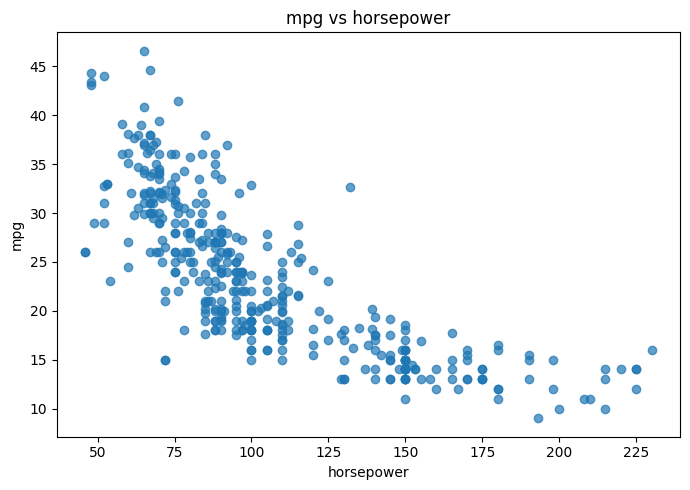

In [9]:
# Scatter plot
plt.figure(figsize=(7, 5))
plt.scatter(Auto["horsepower"], Auto["mpg"], alpha=0.7)
plt.xlabel("horsepower")
plt.ylabel("mpg")
plt.title("mpg vs horsepower")
plt.tight_layout()
plt.show()

## Interpretation
The scatter plot shows that mpg tends to decrease as horsepower increases. The pattern is not perfectly straight across the entire range, which motivates also fitting a quadratic model that can capture curvature rather than forcing the relationship to be linear.

In [11]:
# Linear model
X_lin = sm.add_constant(Auto["horsepower"])
y = Auto["mpg"]
linear_fit = sm.OLS(y, X_lin).fit()
linear_fit.params, linear_fit.bse

(const         39.935861
 horsepower    -0.157845
 dtype: float64,
 const         0.717499
 horsepower    0.006446
 dtype: float64)

In [12]:
# Linear bootstrap
def bootstrap_linear(data, B=1000, seed=1):
    rng = np.random.default_rng(seed)
    n = data.shape[0]
    betas = np.empty((B, 2))
    for b in range(B):
        idx = rng.integers(0, n, n)
        s = data.iloc[idx]
        fitb = sm.OLS(s["mpg"], sm.add_constant(s["horsepower"])).fit()
        betas[b] = fitb.params.values
    se = betas.std(axis=0, ddof=1)
    return se, betas

se_boot_lin, betas_lin = bootstrap_linear(Auto, B=1000, seed=1)
se_boot_lin

array([0.8741882 , 0.00758102])

## Interpretation
This table summarizes the coefficient estimates and two different standard error estimates for the linear model. The model-based standard errors come from the fitted regression model under its usual assumptions, while the bootstrap standard errors come from how much the coefficients vary across many resamples of the dataset drawn with replacement. If the bootstrap standard errors are slightly larger, it suggests that the variability seen through resampling is a bit higher than what the idealized model assumptions imply, which is plausible when the relationship is not perfectly linear.

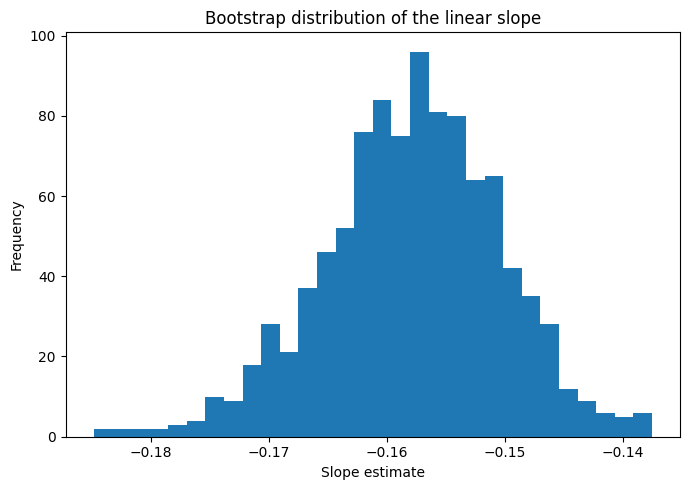

In [13]:
# Linear bootstrap histogram
plt.figure(figsize=(7, 5))
plt.hist(betas_lin[:, 1], bins=30)
plt.title("Bootstrap distribution of the linear slope")
plt.xlabel("Slope estimate")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

## Interpretation
The histogram displays the bootstrap distribution of the slope estimate in the linear model. The spread of this distribution corresponds to the bootstrap standard error and provides a visual sense of how uncertain the slope estimate is under repeated resampling of the observed data.

In [14]:
# Quadratic model
Auto["horsepower2"] = Auto["horsepower"] ** 2
X_quad = sm.add_constant(Auto[["horsepower", "horsepower2"]])
quadratic_fit = sm.OLS(y, X_quad).fit()
quadratic_fit.params, quadratic_fit.bse

(const          56.900100
 horsepower     -0.466190
 horsepower2     0.001231
 dtype: float64,
 const          1.800427
 horsepower     0.031125
 horsepower2    0.000122
 dtype: float64)

In [15]:
# Quadratic bootstrap
def bootstrap_quadratic(data, B=1000, seed=1):
    rng = np.random.default_rng(seed)
    n = data.shape[0]
    betas = np.empty((B, 3))
    for b in range(B):
        idx = rng.integers(0, n, n)
        s = data.iloc[idx].copy()
        s["horsepower2"] = s["horsepower"] ** 2
        fitb = sm.OLS(s["mpg"], sm.add_constant(s[["horsepower", "horsepower2"]])).fit()
        betas[b] = fitb.params.values
    se = betas.std(axis=0, ddof=1)
    return se, betas

se_boot_quad, betas_quad = bootstrap_quadratic(Auto, B=1000, seed=1)
se_boot_quad

array([2.04230915e+00, 3.26586756e-02, 1.18494366e-04])

In [16]:
# Quadratic comparison
quadratic_compare = pd.DataFrame(
    {"Estimate": quadratic_fit.params, "SE_model": quadratic_fit.bse, "SE_bootstrap": se_boot_quad},
    index=["Intercept", "horsepower", "horsepower2"]
)
quadratic_compare

,Estimate,SE_model,SE_bootstrap
Intercept,NaN,NaN,2.042309
horsepower,-0.466190,0.031125,0.032659
horsepower2,0.001231,0.000122,0.000118


## Interpretation
This table provides the same comparison for the quadratic model, now including a coefficient for the squared horsepower term. When a model captures the systematic pattern in the data more accurately, it is common to see closer agreement between model-based and bootstrap standard errors because both methods are reflecting a similar level of variability in the fitted parameters. In this setting, allowing curvature can reduce leftover structure in the residuals and lead to more consistent uncertainty estimates across the two approaches.

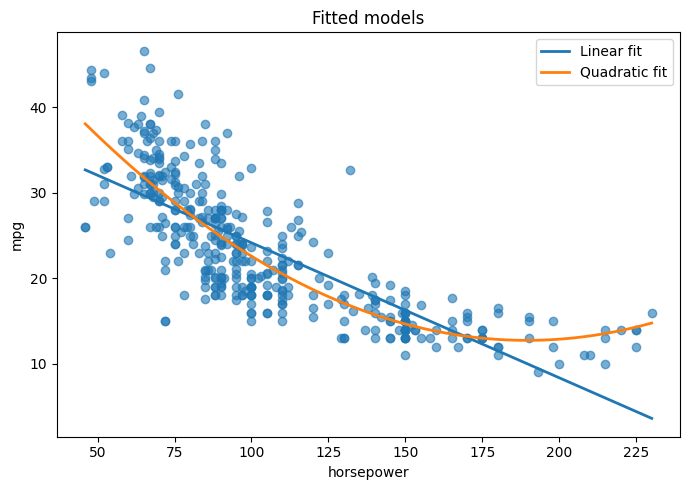

In [17]:
# Fitted curves
x = Auto["horsepower"].to_numpy()
xg = np.linspace(x.min(), x.max(), 300)
yg_lin = linear_fit.predict(sm.add_constant(xg))
yg_quad = quadratic_fit.predict(sm.add_constant(np.column_stack([xg, xg**2])))

plt.figure(figsize=(7, 5))
plt.scatter(Auto["horsepower"], Auto["mpg"], alpha=0.6)
plt.plot(xg, yg_lin, linewidth=2, label="Linear fit")
plt.plot(xg, yg_quad, linewidth=2, label="Quadratic fit")
plt.xlabel("horsepower")
plt.ylabel("mpg")
plt.title("Fitted models")
plt.legend()
plt.tight_layout()
plt.show()

## Interpretation
The overlaid curves make the difference between the two models clear. The linear fit captures the overall downward trend but cannot adapt to curvature, while the quadratic fit follows the shape of the data more closely across both low and high horsepower values. This visual check supports why it is meaningful to estimate and compare standard errors for both models rather than relying on only the linear specification.

## Conclusion
In the linear model, the uncertainty in the parameters can differ slightly between the model-based standard errors and the bootstrap standard errors because the resampling approach reflects the variability present in the observed data without relying as heavily on idealized assumptions. In the quadratic model, allowing curvature typically provides a better description of the mpg–horsepower pattern, and in that case the model-based and bootstrap standard errors often agree more closely. Overall, bootstrap standard errors serve as a practical, data-driven validation of the uncertainty estimates for regression parameters.